# Using Neural Nerwork To Solve The Newclassical Growth Model

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

## Define The Neural Network: layer, width, activation function

In [2]:
class NN(nn.Module):
    def __init__(self, 
                 dim_hidden = 128,
                layers = 3,
                hidden_bias = True):
        super().__init__()
        self.dim_hidden= dim_hidden
        self.layers = layers
        self.hidden_bias = hidden_bias
        
        torch.manual_seed(123)
        module = []
        module.append(nn.Linear(1,self.dim_hidden, bias = self.hidden_bias))
        module.append(nn.ReLU())
        
        for i in range(self.layers-1):
            module.append(nn.Linear(self.dim_hidden,self.dim_hidden, bias = self.hidden_bias))
            module.append(nn.ReLU())  
            
        module.append(nn.Linear(self.dim_hidden,1))
        
        self.u = nn.Sequential(*module)


    def forward(self, x):
        u_out = self.u(x)
        return  u_out

## Define The Parameters: discount rate, depreciation rate, risk aversion, capital range

In [3]:
class Data:
    def __init__(self,
                 beta = 0.9,
                 alpha = 0.5,
                 sigma= 1, #risk aversion
                 gamma= 0.15, #discount rate
                 kmax = 12.0, 
                 kmin =  2.1,
                 dist = 0.1,
                 num = 100,
                 batch_size = 25
                ):
        self.beta = beta
        self.alpha = alpha
        self.sigma = sigma
        self.gamma = gamma
        self.kmax = kmax
        self.kmin = kmin
        self.dist= dist
        self.num = num
        self.batch_size = batch_size
        
        self.K_t = torch.zeros([self.num])
        self.K_t[0] = self.kmin
        for t in range(self.num-1):
            self.K_t[t+1] = self.dist + self.K_t[t] #K_t is the range of the capital
                    
        self.train_data = torch.stack((self.K_t,self.K_t),1)

In [4]:
from torch.utils.data import Dataset, DataLoader

In [5]:
class Data_loader(Dataset):
    
    def __init__(self,data):
        self.data = data
        self.K = self.data[:,[0]]
        self.n_samples = self.data.shape[0]

    def __getitem__(self,index):
            return self.K[index]
        
    def __len__(self):
        return self.n_samples

In [6]:
data_set = Data().train_data
data_label = Data_loader(data = data_set)
print(data_set.shape[0])
batch_size = Data().batch_size
train = DataLoader(dataset = data_label, batch_size = batch_size, shuffle = True)

100


In [7]:
α = Data().alpha
γ = Data().gamma
β = Data().beta
σ = Data().sigma
print(α)

0.5


In [8]:
max_epochs = 1001

In [9]:
c_hat = NN()
learning_rate = 3e-3

optimizer = torch.optim.Adam(c_hat.parameters(), lr=learning_rate, weight_decay=0.0)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)

## Define The Loss Function and Start Learning Process

In [10]:
for epoch in range(max_epochs):
    for index, K in enumerate(train):
        
        K_prime=K.pow(α)+(1-γ)*K-c_hat(K)
        euler_res = c_hat(K).pow(σ)*β*(c_hat(K_prime).pow(-σ))*(1-γ+α*K_prime.pow(α-1))-1
        
        loss = euler_res.pow(2).mean()
       
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
    scheduler.step()
    if epoch % 100 == 0:
        #print("epoch:",",",epoch,',',"{:.2e}".format(loss.item()),',',"{:.2e}".format(get_lr(optimizer))) 
        print("epoch:",epoch, ",","MSE Euler Residuals:","{:.2e}".format(loss.item()))    


epoch: 0 , MSE Euler Residuals: 1.45e-01
epoch: 100 , MSE Euler Residuals: 1.06e-04
epoch: 200 , MSE Euler Residuals: 5.11e-05
epoch: 300 , MSE Euler Residuals: 4.19e-05
epoch: 400 , MSE Euler Residuals: 3.74e-05
epoch: 500 , MSE Euler Residuals: 2.89e-05
epoch: 600 , MSE Euler Residuals: 2.32e-05
epoch: 700 , MSE Euler Residuals: 2.40e-05
epoch: 800 , MSE Euler Residuals: 2.18e-05
epoch: 900 , MSE Euler Residuals: 2.55e-05
epoch: 1000 , MSE Euler Residuals: 2.26e-05


In [11]:
c_hat.eval()
K = Data().train_data[:,[0]]
approx_sol = c_hat(K).detach()
K_prime=K.pow(α)+(1-γ)*K-approx_sol

## Plot The Results

In [12]:
import matplotlib.pyplot as plt

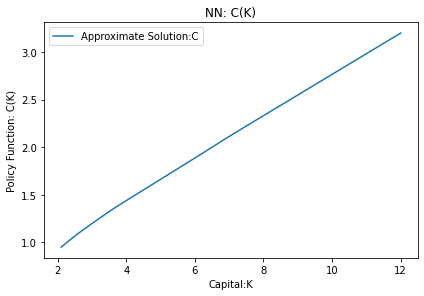

In [13]:
plt.plot(K,approx_sol,label= r"Approximate Solution:C" )
plt.ylabel(r"Policy Function: C(K)")
plt.xlabel(r"Capital:K")
plt.tight_layout()
plt.legend(loc='best')
plt.savefig("Consumpt.pdf")
plt.title("NN: C(K)")
plt.show()

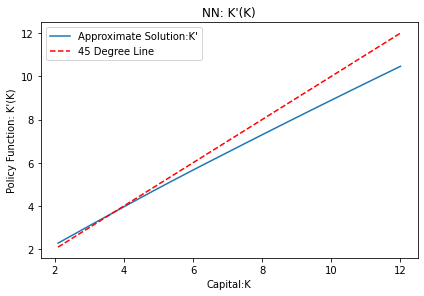

In [22]:
plt.plot(K,K_prime,label= r"Approximate Solution:K'" )
plt.plot(K,K, "--", color='r', label= r"45 Degree Line")
plt.ylabel(r"Policy Function: K'(K)")
plt.xlabel(r"Capital:K")
plt.tight_layout()
plt.legend(loc='best')
plt.savefig("K_prime.pdf")
plt.title("NN: K'(K)")
plt.show()

# Using Policy Function Iteration For Comparasion

In [15]:
import numpy as np
from scipy import interpolate 

In [16]:
beta = 0.9;
alpha = 0.5;
sigma= 1;
gamma= 0.15;
kmax = 12.1; 
kmin =  2.1;
dist = 0.1;
num = 100;
K_n=np.arange(kmin,kmax,dist);

In [17]:
C_n=0.5*K_n; #initial value of C(K)

d=1;
tol=1e-10;
N=0;

while  d>tol:
    Kp=K_n**alpha+(1-gamma)*K_n-C_n;
    Iterp1=interpolate.interp1d(K_n,C_n)
    Cp=Iterp1(Kp);
    Cnew=Cp*(beta*(alpha*K_n**(alpha-1)+1-gamma))**(-1/sigma);
    d=max(abs(Cnew-C_n));
    C_n=Cnew;
    N=N+1

In [18]:
Kp=K_n**alpha+(1-gamma)*K_n-C_n;

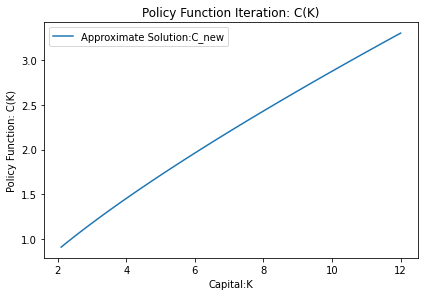

In [19]:
plt.plot(K_n,C_n,label= r"Approximate Solution:C_new" )
plt.ylabel(r"Policy Function: C(K)")
plt.xlabel(r"Capital:K")
plt.tight_layout()
plt.legend(loc='best')
plt.savefig("Consumpt_0.pdf")
plt.title("Policy Function Iteration: C(K)")
plt.show()

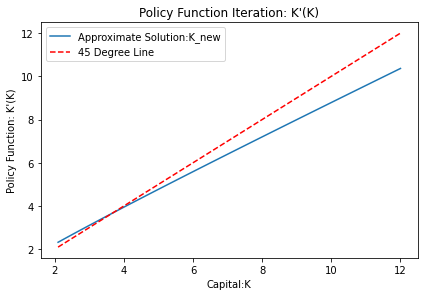

In [23]:
plt.plot(K_n,Kp,label= r"Approximate Solution:K_new" )
plt.plot(K,K, "--", color='r', label= r"45 Degree Line")
plt.ylabel(r"Policy Function: K'(K)")
plt.xlabel(r"Capital:K")
plt.tight_layout()
plt.legend(loc='best')
plt.savefig("K_prime_0.pdf")
plt.title("Policy Function Iteration: K'(K)")
plt.show()

# Differences Between Two Approaches

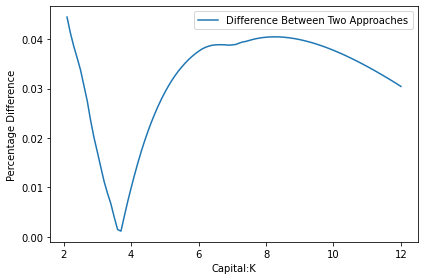

In [21]:
C_0=c_hat(K).detach().numpy()
C_1=C_n.reshape(num,1)
Distance=abs(C_1-C_0)/C_1
plt.plot(K_n,Distance,label= r"Difference Between Two Approaches" )
plt.ylabel(r"Percentage Difference")
plt.xlabel(r"Capital:K")
plt.tight_layout()
plt.legend(loc='best')
plt.savefig("Distance.pdf")
plt.show()